# SD212: Graph mining
## Lab 6: Diffusion in graphs

In this lab, you will learn to use diffusion for ranking and classifying the nodes of a graph. We only consider the Dirichlet approach.

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse

In [3]:
from sknetwork.data import load_netset, grid, karate_club
from sknetwork.classification import DirichletClassifier, BiDirichletClassifier
from sknetwork.ranking import Dirichlet, BiDirichlet, PageRank, BiPageRank, top_k
from sknetwork.utils import membership_matrix
from sknetwork.visualization import svg_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [4]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')
cinema = load_netset('cinema')

Parsing files...
Done.
Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Grid

We first illustrate the ability of diffusion to rank nodes in the presence of hot sources and cold sources, as the solution to the Dirichlet problem.

In [5]:
k = 12
graph = grid(k, k, True)
adjacency = graph.adjacency
position = graph.position

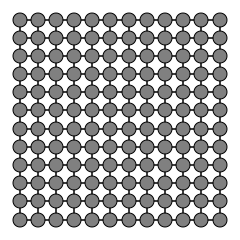

In [6]:
image = svg_graph(adjacency, position, width=200, height=200)
SVG(image)

## To do

* Display the solution to the Dirichlet problem with 1 hot source and 1 cold source, located on the ends of a diagonal.
* Add 1 hot source at a location of your choice and observe the result.
* Display the graph with hot sources on one diagonal of the square and 1 cold source on one end of the other diagonal of the square. What is the temperature of the other end of the diagonal? Observe the sensitivity of the result to the parameter ``n_iter`` of the object ``Dirichlet``.

##### 1 hot, 1 cold

In [7]:
dirichlet = Dirichlet()

In [8]:
first_diagonal = (k + 1) * np.arange(k)
second_diagonal = (k - 1) * (np.arange(k) + 1)

In [9]:
first_diagonal

array([  0,  13,  26,  39,  52,  65,  78,  91, 104, 117, 130, 143])

In [10]:
second_diagonal

array([ 11,  22,  33,  44,  55,  66,  77,  88,  99, 110, 121, 132])

In [12]:
seeds = {first_diagonal[0]: 0, first_diagonal[-1]: 1}

In [13]:
scores = dirichlet.fit_transform(adjacency, seeds)

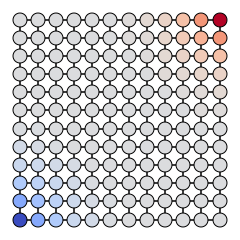

In [14]:
image = svg_graph(adjacency, position, scores=scores, width=200, height=200)
SVG(image)

##### 2 hot, 1 cold

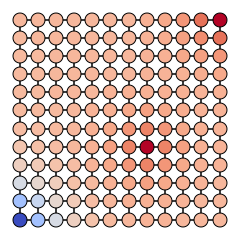

In [20]:
seeds = {first_diagonal[0]: 0, first_diagonal[-1]: 1, second_diagonal[7]: 1}
scores = dirichlet.fit_transform(adjacency, seeds)
image = svg_graph(adjacency, position, scores=scores, width=200, height=200)
SVG(image)

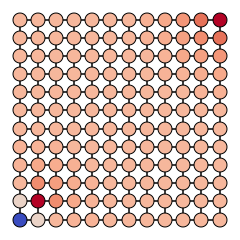

In [22]:
seeds = {first_diagonal[0]: 0, first_diagonal[-1]: 1, first_diagonal[1]: 1}
scores = dirichlet.fit_transform(adjacency, seeds)
image = svg_graph(adjacency, position, scores=scores, width=200, height=200)
SVG(image)

##### hot diagonal

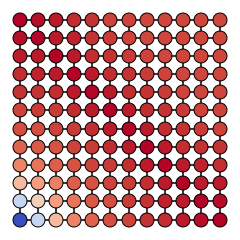

In [24]:
# with default sensitivity of 10 iterations
seeds = dict(zip(second_diagonal, np.ones(k)))
seeds[0] = 0
scores = dirichlet.fit_transform(adjacency, seeds)
image = svg_graph(adjacency, position, scores=scores, width=200, height=200)
SVG(image)

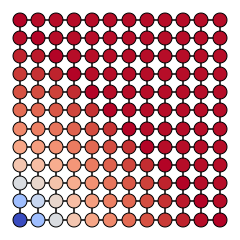

In [30]:
# with an improved sensitivity of 1000 iteration
dirichlet = Dirichlet(n_iter=1000)
seeds = dict(zip(second_diagonal, np.ones(k)))
seeds[0] = 0
scores = dirichlet.fit_transform(adjacency, seeds)
image = svg_graph(adjacency, position, scores=scores, width=200, height=200)
SVG(image)

In [31]:
dirichlet.scores_

array([0.        , 0.30835431, 0.49468177, 0.62328298, 0.71970223,
       0.79545534, 0.8562346 , 0.90498486, 0.94321577, 0.97164302,
       0.99054767, 1.        , 0.30835431, 0.43038117, 0.55240802,
       0.65546494, 0.74036837, 0.81042919, 0.86826361, 0.91550422,
       0.95301942, 0.98116561, 1.        , 1.        , 0.49468177,
       0.55240802, 0.62910421, 0.70580039, 0.77587711, 0.83762944,
       0.89088643, 0.93574898, 0.9721921 , 1.        , 1.        ,
       1.        , 0.62328298, 0.65546494, 0.70580039, 0.76275531,
       0.81971023, 0.87332503, 0.92190368, 0.96441316, 1.        ,
       1.        , 1.        , 1.        , 0.71970223, 0.74036837,
       0.77587711, 0.81971023, 0.86688349, 0.91405675, 0.95899011,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.79545534, 0.81042919, 0.83762944, 0.87332503, 0.91405675,
       0.95702838, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.8562346 , 0.86826361, 0.89088

We notice how improving the sensitivity got the part behind the diagonal to converge towards 1, heating all the nodes from that side to the source temperature of 1.

## Karate Club


We now consider the classification of nodes by the Dirichlet method. We use the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) that has ground-truth labels.

In [241]:
graph = karate_club(True)

In [242]:
adjacency = graph.adjacency
position = graph.position
labels_true = graph.labels

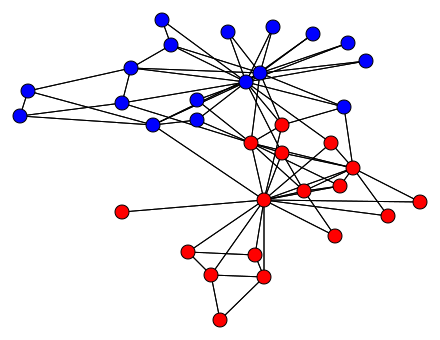

In [34]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Select 2 seeds, one in each cluster, and display the graph with the predicted labels. What is the accuracy of the classification?
* Display the graph with the temperature of each node at equilibrium.
* Give the accuracy averaged over 100 experiments with 2 seeds selected at random, one in each cluster.
* Display the graph with the two most frequently misclassified nodes.

##### Classification with 2 seeds

In [87]:
classifier = DirichletClassifier(n_iter=10)
seeds = {32: 0, 0:1}
labels = classifier.fit_transform(adjacency, seeds)
print("the accuracy of this classification is {:.3%}".format(sum(labels == labels_true)/len(labels)))

the accuracy of this classification is 97.059%


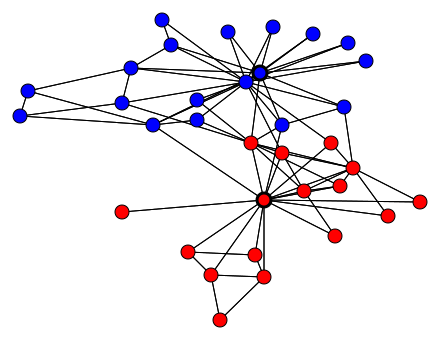

In [88]:
image = svg_graph(adjacency, position, labels=labels, seeds=seeds)
SVG(image)

##### Temperatures preview

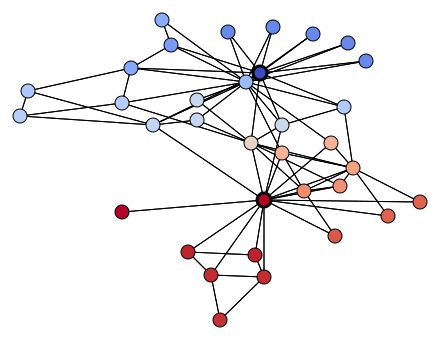

In [115]:
scores = classifier.score(1) # the temperatures

image = svg_graph(adjacency, position, scores=scores, seeds=seeds)
SVG(image)

In [122]:
# verification
my_labels = np.array(scores >= np.mean(scores), dtype=int)

(my_labels == labels).all()

True

##### Accuracy averaged over 100 experiments with 2 seeds selected at random, one in each cluster.

In [144]:
hot = np.where(labels_true==1)[0]
cold = np.where(labels_true==0)[0]
classifier = DirichletClassifier(n_iter=10)

accuracy = 0
for i in range(1, 101):
    labels = classifier.fit_transform(adjacency,
                             {np.random.choice(hot): 1,
                              np.random.choice(cold): 0})
    accuracy += sum(labels == labels_true)/len(labels)
    if (i%10 == 0):
        print("epoch {:}: {:.3%}".format(i, accuracy/i))

print(accuracy/100)

epoch 10: 95.882%
epoch 20: 95.000%
epoch 30: 93.529%
epoch 40: 93.309%
epoch 50: 93.118%
epoch 60: 92.647%
epoch 70: 92.773%
epoch 80: 93.235%
epoch 90: 93.627%
epoch 100: 93.735%


0.9373529411764694

##### Graph with the two most frequently misclassified nodes

In [244]:
hot = np.where(labels_true==1)[0]
cold = np.where(labels_true==0)[0]
classifier = DirichletClassifier(n_iter=10)

misclassifications = np.zeros(len(labels_true))
for i in range(1, 101):
    seeds = {np.random.choice(hot): 1, np.random.choice(cold): 0}
    labels = classifier.fit_transform(adjacency, seeds)
    
    for j, label in enumerate(labels):
        if label != labels_true[j]:
            misclassifications[j] += 1

In [246]:
top_k(misclassifications, 2)

array([8, 2], dtype=int64)

the worst accuracy was 94.118%


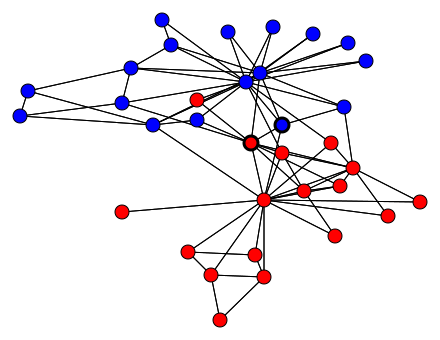

In [248]:
image = svg_graph(adjacency, position, labels=labels, seeds=dict(zip(top_k(misclassifications, 2), [1, 1])))
print("the worst accuracy was {:.3%}".format(accuracy))
SVG(image)

Hence, the 2 most misclassified nodes are the ones on the boundaries. Usually, these are the two usually misclassified nodes using PageRank too.

##### Graph with the two worst seeds leading to the worst classification

In [155]:
hot = np.where(labels_true==1)[0]
cold = np.where(labels_true==0)[0]
classifier = DirichletClassifier(n_iter=10)

worst_accuracy = 1
cum_accuracy = 0
for i in range(1, 101):
    seeds = {np.random.choice(hot): 1, np.random.choice(cold): 0}
    labels = classifier.fit_transform(adjacency, seeds)
    accuracy = sum(labels == labels_true)/len(labels)
    
    if accuracy < worst_accuracy:
        worst_labels = labels
        worst_seeds = seeds
        worst_accuracy = accuracy
    cum_accuracy += accuracy 
    if (i%10 == 0):
        print("epoch {:}: {:.3%}".format(i, cum_accuracy/i))

epoch 10: 89.706%
epoch 20: 91.471%
epoch 30: 92.059%
epoch 40: 91.912%
epoch 50: 92.235%
epoch 60: 92.941%
epoch 70: 92.815%
epoch 80: 92.978%
epoch 90: 92.908%
epoch 100: 92.794%


In [240]:
worst_seeds

{8: 1, 24: 0}

the worst accuracy was 67.647%


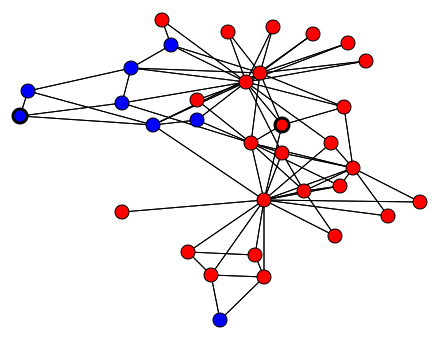

In [156]:
image = svg_graph(adjacency, position, labels=worst_labels, seeds=worst_seeds)
print("the worst accuracy was {:.3%}".format(worst_accuracy))
SVG(image)

It would have been even worse if the `n_iter` was also bigger. We wouldn't see that blue node in the bottom!

## Openflights


We now classify the nodes of a graph without labels, to get the local structure of the graph.

In [157]:
graph = openflights

In [158]:
adjacency = graph.adjacency
position = graph.position
names = graph.names

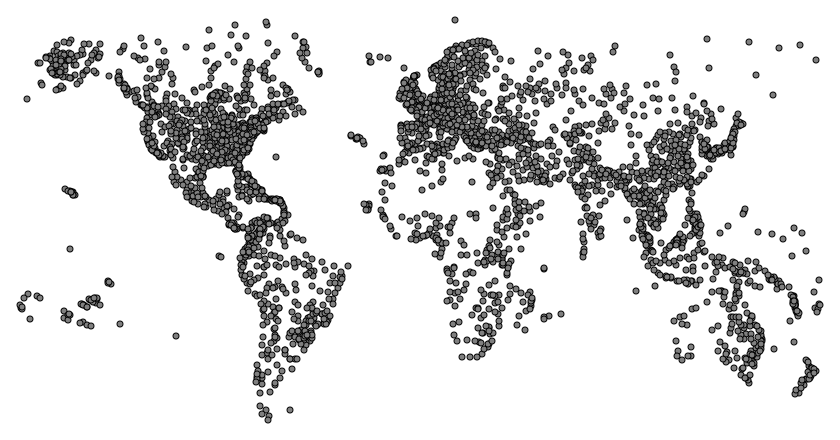

In [159]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with the labels predicted for 3 seeds (Paris, New-York, Beijing), each with its own  label.
* Add a seed in Madrid with another label and observe the result.

##### 3-way classification

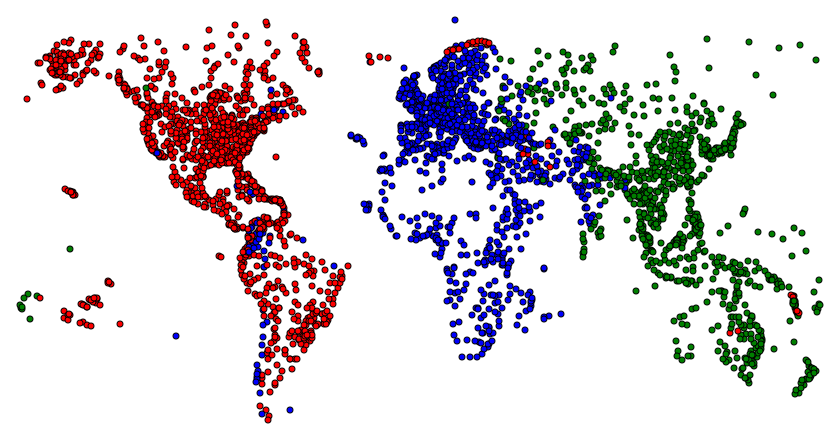

In [160]:
paris = 622
newyork = 1842
beijing = 1618

classifier = DirichletClassifier(n_iter=10)
seeds = {paris: 0, newyork: 1, beijing: 2}
labels = classifier.fit_transform(adjacency, seeds)
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False,
                     labels=labels)
SVG(image)

##### Adding Madrid, and more iterations/

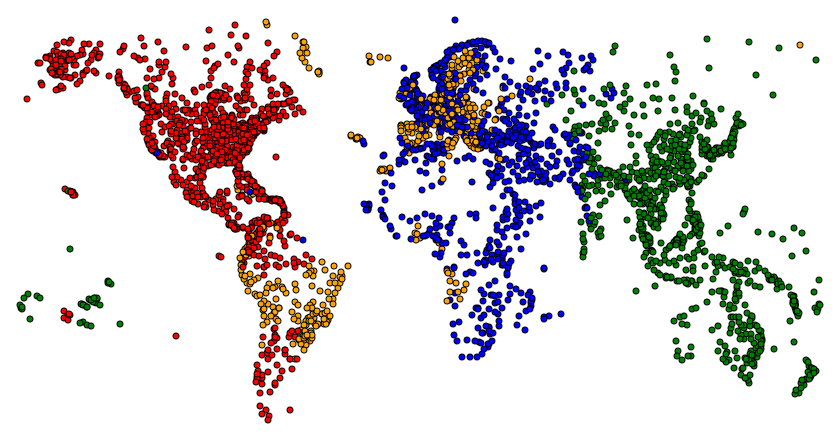

In [163]:
madrid = 572

classifier = DirichletClassifier(n_iter=100)
seeds = {paris: 0, newyork: 1, beijing: 2, madrid: 3}
labels = classifier.fit_transform(adjacency, seeds)
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False,
                     labels=labels)
SVG(image)

## To do

* List the top-10 airports that are close to Tokyo and far from Paris using the Dirichlet method.
* Observe the scores and explain the result.
* Check your guess on displaying the following aggregate graph: Tokyo, top-10 airports except Tokyo, rest of the world.<br>**Hint:** Use the function ``membership_matrix``.

##### Top-10 closest to Tokyo and farthest from Paris in number of hops:

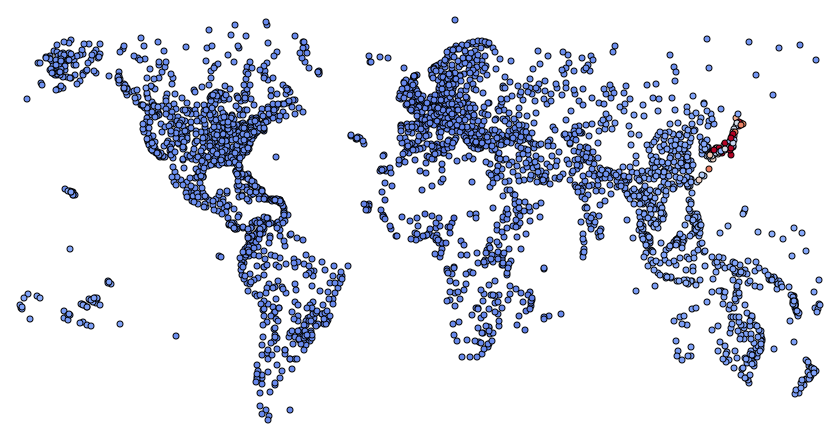

In [173]:
tokyo = 1084
dirichlet = Dirichlet(n_iter=1000)

seeds = {tokyo: 1, paris:0}
distances = dirichlet.fit_transform(adjacency, seeds)

image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False,
                         scores=distances)
SVG(image)

In [197]:
print("The closest airports to Tokyo and farthest from Paris are: (in number of hops)")
for n in names[top_k(distances, 10)]:
    print("\t-", n)

The closest airports to Tokyo and farthest from Paris are: (in number of hops)
	- Odate Noshiro Airport
	- Shonai Airport
	- Kitakyūshū Airport
	- Monbetsu Airport
	- Tottori Airport
	- Tokushima Airport
	- Izumo Airport
	- Nanki Shirahama Airport
	- Tokachi-Obihiro Airport
	- Tokyo Haneda International Airport


In [198]:
distances[top_k(distances, 10)]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

We notice that the top close airports from Tokyo all reached a temperature of 1, which is Tokyo's temperature, which means that they are very close to Tokyo and very far from Paris simultaneously.

Augmenting the `n_iter` will change this convergence, but will always keep Tokyo at 1

In [196]:
print("The closest airports to Paris and farthest from Tokyo are:")
for n in names[top_k(-distances, 10)]:
    print("\t-", n)

The closest airports to Paris and farthest from Tokyo are:
	- Charles de Gaulle International Airport
	- N'Djamena International Airport
	- Annaba Airport
	- Diori Hamani International Airport
	- Garoua International Airport
	- Sfax Thyna International Airport
	- Nouakchott International Airport
	- Lungi International Airport
	- Mohamed Boudiaf International Airport
	- Yaoundé Nsimalen International Airport


##### Aggregate graph: Tokyo, top-10 airports except Tokyo, rest of the world.

## 2. Directed graphs

## Wikipedia Vitals

In [199]:
graph = wikivitals

In [200]:
adjacency = graph.adjacency
names = graph.names

## To do

* List the top-10 articles that are close to **Cat** and **Dog** in terms of Personalized BiPageRank.
* Compare with the list of top-10 articles that are close to **Cat** and **Dog** and far from **Bear** and **Tiger** using diffusion.
* List the top-10 articles that are close to **Bear** and **Tiger** and far from **Cat** and **Dog**. **Hint:** You can use previous diffusion.

##### Closest to Cat and Dog, via BiPageRank

In [210]:
cat = 1401
dog = 1395

pagerank = BiPageRank()
scores0 = pagerank.fit_transform(adjacency)
seeds = {cat:1, dog:1}
scores = pagerank.fit_transform(adjacency, seeds) - scores0
for n in names[top_k(scores, 12)][2:]:
    print(n)

Coyote
Bear
European badger
Pinniped
Wolf
Brown bear
Cougar
Tiger
Lion
Cheetah


##### Closest to Cat and Dog and farthest from Bear and Tiger, via Dirichlet

In [217]:
bear = 1390
tiger = 1410

dirichlet = Dirichlet(n_iter=1000)
seeds = {dog: 1, cat:1, bear:0, tiger:0}
distances = dirichlet.fit_transform(adjacency, seeds)

for n in names[top_k(distances, 12)][2:]:
    print(n)

Domestic short-haired cat
Terrier
Siamese cat
Retriever
Horned lizard
Greyhound
German Shepherd
Mouse
Moulting
Skink


##### Closest to Bear and Tiger and farthest from Cat and Dog, via Dirichlet

In [221]:
for n in names[top_k(-distances, 12)][2:]:
    print(n)

Serranidae
Hibernation
Taxidermy
Mysore
Mount St. Helens
Nanyue
Endangered species
Tapir
Earthworm
Zoo


## 3. Bipartite graphs

## Cinema

In [222]:
graph = cinema

In [223]:
biadjacency = graph.biadjacency
movies = graph.names_row
actors = graph.names_col

## To do

* List the top-20 movies that are close to **Taxi Driver** and **Drive** in terms of Personalized PageRank. What is the rank of **Finding Nemo**?
* List the top-20 movies that are close to **Taxi Driver** and **Drive** and far from **Finding Nemo** using diffusion.

In [238]:
taxi = 63668
drive = 19744

pagerank = BiPageRank()
scores0 = pagerank.fit_transform(biadjacency)
seeds = {taxi:1, drive:1}
scores = pagerank.fit_transform(biadjacency, seeds) - scores0
for n in movies[top_k(scores, 22)][2:]:
    print(n)

A Most Violent Year
Finding Nemo
Finding Dory
Exploring the Reef
The Simpsons Movie
Inside Llewyn Davis
I'll Do Anything
The Secret Life of Pets
The Little Prince (2015 film)
This Is 40
Unfaithfully Yours (1984 film)
The In-Laws (2003 film)
Concussion (2015 film)
Critical Care
My First Mister
Out of Sight
The Scout
Broadcast News
Detachment
Wildlife


Hence, Finding Nemo's rank is 2nd.

In [239]:
nemo = 22770

dirichlet = BiDirichlet()
seeds = {taxi: 1, drive:1, nemo:0}
distances = dirichlet.fit_transform(biadjacency, seeds)

for n in movies[top_k(distances, 22)][2:]:
    print(n)

Wildlife
Stormy Weathers (1992 film)
Listen to Your Heart (2010 film)
Northanger Abbey (2007 film)
Never Let Me Go (2010 film)
The Greatest (2009 film)
Young Hercules
La La Land
Blade Runner 2049
The Slaughter Rule
Special Delivery (1976 film)
Blue Valentine
At Long Last Love
Shame (2011 film)
'Twas the Night
Inside Llewyn Davis
My Boy Jack
Forget Us Not
Mudbound
Half Nelson
